In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_CIFAR10():
    train_dataset = datasets.CIFAR10(root='data/', download=True, train=True, transform=ToTensor())
    test_dataset = datasets.CIFAR10(root='data/', download=True, train=False, transform=ToTensor())

    np.set_printoptions(threshold=np.inf)

    X_train = train_dataset.data
    X_test = test_dataset.data

    y_train = np.array(train_dataset.targets)
    y_test = np.array(test_dataset.targets)

    X_train = X_train.reshape(50000, 32 * 32 * 3)
    X_test = X_test.reshape(10000, 32 * 32 * 3)
    
    '''
    X_train = X_train[:10000]
    X_test = X_test[:1000]

    y_train = y_train[:10000]
    y_test = y_test[:1000]
    '''
    
    X_train = X_train.astype("float")
    X_test = X_test.astype("float")

    return X_train, y_train, X_test, y_test


In [3]:
def distance(data_set, cores, k):
    distances = np.zeros((data_set.shape[0], k))

    d1 = np.multiply(np.dot(data_set, cores.T), -2)
    d2 = np.sum(np.square(cores.T), axis=0, keepdims=True)
    d3 = np.sum(np.square(data_set), axis=1, keepdims=True)

    distances = np.sqrt(d1 + d2 + d3)
    return distances

In [4]:
def k_means(X_train, y_train, k):
    # m = the number of train set
    # n = the number of all pixels of the image in train set
    m, n = X_train.shape

    # Clustering results for m samples,
    # each of which corresponds to a clustering ordinal number
    result = np.empty(m, dtype=np.int32)

    # Random initialization of k centroids
    cores = X_train[np.random.choice(np.arange(m), k, replace=False)]

    # k labels corresponding to the K clusters
    label_of_clusters = np.empty(k, dtype=np.int32)

    while True:
        distances = distance(X_train, cores, k)

        # The nearest centroid index ordinal number for each sample
        index_min = np.argmin(distances, axis=1)

        # If the sample clustering does not change, return cluster centroid data and cluster labels
        if (index_min == result).all():
            for i in range(k):
                label_of_clusters[i] = np.argmax(np.bincount(y_train[result == i]))
            break
            
        # Reclassify
        result[:] = index_min
        # Traverse the centroid set
        for i in range(k):
            # Find the subset corresponding to the current centroid
            items = X_train[result == i]
            # Takes the mean of the subset as the position of the current centroid
            cores[i] = np.mean(items, axis=0)

    return cores, label_of_clusters

In [5]:
def predict(X_test, cores, label_of_clusters):
    k = label_of_clusters.shape[0]
    m, n = X_test.shape
    # m predictive labels for test samples
    prediction = np.zeros(m)

    distances = distance(X_test, cores, k)

    # The nearest centroid index ordinal number for each sample
    index_min = np.argmin(distances, axis=1)
    prediction = label_of_clusters[index_min]

    return prediction

In [6]:
def calculate_accuracy(y_test, prediction, verbose=False):
    num_test = y_test.shape[0]
    num_correct = np.sum(prediction == y_test)
    accuracy = num_correct / num_test
    if verbose:
        print('Correct %d/%d: The test accuracy: %f' % (num_correct, num_test, accuracy))
    return accuracy

In [7]:
def cross_validation(X_train, y_train, k_set):
    print("-------------------cross validation starts-------------------")
    num_folds = 5    # k-fold value = 5
    
    best_accuracy = -1
    best_k = 0
    
    # divide both X_train and y_train into 5 parts, 
    # 4 of them are train set and the left one is the test set
    X_train_folds = np.array_split(X_train, num_folds)
    y_train_folds = np.array_split(y_train, num_folds)

    accuracys = np.zeros(len(k_set), dtype=np.float64)
    
    # Take 4 of them for training, 1 of them for verification by using loop
    for i in range(num_folds):
        X_tr = np.reshape(np.array(X_train_folds[:i] + X_train_folds[i + 1:]),
                          (int(X_train.shape[0] * (num_folds - 1) / num_folds), -1))
        y_tr = np.reshape(y_train_folds[:i] + y_train_folds[i + 1:],
                          int(y_train.shape[0] * (num_folds - 1) / num_folds))
        X_te = X_train_folds[i]
        y_te = y_train_folds[i]

        for j in range(len(k_set)):
            cores, label_of_clusters = k_means(X_tr, y_tr, k_set[j])
            y_prediction = predict(X_te, cores, label_of_clusters)
            accuracys[j] += calculate_accuracy(y_te, y_prediction, verbose=False)
            
            if(accuracys[j] > best_accuracy):
                best_accuracy = accuracys[j]
                best_k = k_set[j]
                
    accuracys /= num_folds
    for j in range(len(k_set)):
        print("k =", k_set[j])
        print("the average accuracy of %d train folds is %f" % (num_folds, accuracys[j]))
        print('\n' + "-------------------------------------------------------" + '\n')
    plt.plot(k_set, accuracys)
    plt.ylabel('average accuracy')
    plt.xlabel('k')
    plt.title("cross-validation on k")
    plt.show()
    
    print("The best k with highest average accuracy is", best_k)
    print()
    return best_k

In [8]:
def test_data_validation(X_test, y_test, X_train, y_train, k):
    print("-------------------test data validation starts-------------------")

    print()
    print("The best k we get from the cross validation is", k)
    
    cores, label_of_clusters = k_means(X_train, y_train, k)
    y_prediction = predict(X_test, cores, label_of_clusters)
    accuracy = calculate_accuracy(y_test, y_prediction, verbose=True)


Files already downloaded and verified
Files already downloaded and verified
-------------------cross validation starts-------------------
k = 3
the average accuracy of 5 train folds is 0.176840

-------------------------------------------------------

k = 5
the average accuracy of 5 train folds is 0.188020

-------------------------------------------------------

k = 7
the average accuracy of 5 train folds is 0.195000

-------------------------------------------------------

k = 11
the average accuracy of 5 train folds is 0.234540

-------------------------------------------------------



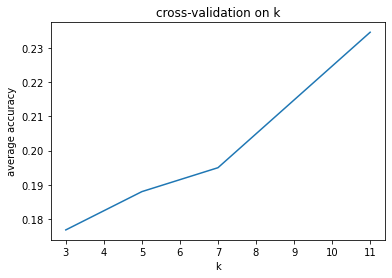

The best k with highest average accuracy is 11

-------------------test data validation starts-------------------

The best k we get from the cross validation is 11
Correct 2224/10000: The test accuracy: 0.222400


In [9]:
X_train, y_train, X_test, y_test = load_CIFAR10()
k_set = [3, 5, 7, 11]
best_k = cross_validation(X_train, y_train, k_set)
test_data_validation(X_test, y_test, X_train, y_train, best_k)